In [8]:
import os
import io
import cv2
import fitz
import PyPDF2
import camelot
import itertools
import pytesseract
import numpy as np
import pandas as pd
from wand.image import Image
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

In [16]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [17]:
os.environ['PATH'] += r';C:\Program Files\Tesseract-OCR'

Обобщим обработку на случай pdf файла на входе, сделаем пердобработку и выполним нарезку

In [113]:
class TableExtraction:
    def __init__(self):
        self.file_path = ''
        # pytesseract config
        self.custom_config = r'--oem 1 --psm 1 -l rus'

    def is_image_based_pdf(self, file_path):
        try:
            pdf_file = open(file_path, 'rb')
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            
            # Read the first page of the PDF
            first_page = pdf_reader.pages[0]
            
            # Check if the page contains any text
            return len(first_page.extract_text().strip()) == 0
        
        except Exception as e:
            print(f"Error: {e}")
            return False
        
    def process_tables(self, file_path):
        tables = camelot.read_pdf(file_path, strip_text='\n', line_scale=40, pages='all', copy_text=['h'])

        if not os.path.exists("results"):
            os.makedirs("results")

        def contains_cid(table):
            for row in table.df.itertuples(index=False):
                for cell in row:
                    if "(cid:" in str(cell):
                        return True
            return False
        
        for idx, table in enumerate(tables, 1):
            if contains_cid(table):
                print(f"Font or encoding error in table")
            else:
                file_name = os.path.basename(file_path)
                output_file = f"results/{os.path.splitext(file_name)[0]}_table_{idx}.csv"
                table.to_csv(output_file, index=False)

    def file_to_array(self, file_path, dpi=200):
        self.images_arrays = []
        file_extension = os.path.splitext(file_path)[1]
        if file_extension == '.pdf':
            images = convert_from_path(file_path, dpi=dpi, poppler_path=r'C:\Program Files\poppler-23.07.0\Library\bin')
            self.images_arrays = [np.array(image) for image in images]
        else:
            raise ValueError('Unsupported file format')

    def grayzation(self):
        self.gray_images = []  
        for image in self.images_arrays:
            self.gray_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    def show_gray_images(self):
        for gray_image in self.gray_images:
            plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def binarization(self):
        self.threshold_images = []
        for gray_image in self.gray_images:
            _, threshold_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)
            self.threshold_images.append(threshold_image)

    def show_threshold_images(self):
        for threshold_image in self.threshold_images:
            plt.imshow(cv2.cvtColor(threshold_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def get_tables(self):
        self.tables_borders = []
        self.tables_bboxes = []
        self.tables = []

        for num, gray_image in enumerate(self.gray_images):
            # Inverted binarizing transform
            ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            # Applying a morphological transformation to remove noise and close lines
            kernel = np.ones((10, 10), np.uint8)
            morph_image = cv2.morphologyEx(threshold_image, cv2.MORPH_CLOSE, kernel)

            # Finding contours in an image
            contours, hierarchy = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            height, width = gray_image.shape
            # Filtering outlines and defining cell bounding boxes
            for contour in contours:
                # Filtering contours by area
                area = cv2.contourArea(contour)
                x, y, w, h = cv2.boundingRect(contour)
                if area > 0.005 * height * width and w > 0.25 * width and h > 0.5 * w:
                    # Adding a bounding box to a list
                    x, y, w, h = cv2.boundingRect(contour)
                    self.tables_bboxes.append((x, y, x + w, y + h))
                    
                    # Crop the table from the sheet
                    croped_gray_image = gray_image[y:y + h, x:x + w]
                    copy_image = croped_gray_image.copy()
                    _, croped_threshold_image = cv2.threshold(croped_gray_image, 200, 255, cv2.THRESH_BINARY)
                    boxes = pytesseract.image_to_boxes(croped_threshold_image, config=self.custom_config)
                    box_lines = boxes.strip().split('\n')
                    boxes_list = [line.split() for line in box_lines]
                    borders = []
                    epsilon = (height + width) * 0.02
                    print(epsilon)

                    # Check if there are lines on the croped image
                    if boxes_list[0] != []:
                        for box in boxes_list:
                            if box[0] == '~' and ((abs(int(box[1]) - int(box[3])) <= epsilon) or (abs(int(box[2]) - int(box[4])) <= epsilon)):
                                x, y, w, h = int(box[1]), int(box[2]), int(box[3]), int(box[4])
                                borders.append([x, y, w, h])
                                cv2.rectangle(copy_image, (x, height - y), (w, height - h), (128, 0, 128), 10)

                    # Отображаем визуализированное изображение
                    plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.show()
                    
                    if len(borders) > 3:
                        self.tables.append(croped_gray_image)
                        self.tables_borders.append(borders)

    def show_table_images(self):
        for table in self.tables:
            plt.imshow(cv2.cvtColor(table, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def extract(self):
        self.tables_lines = []
        self.tables_nodes = []
        self.result = []

        for num, image in enumerate(self.tables):
            # Get character bounding boxes
            height, width = image.shape
            _, croped_threshold_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
            boxes = pytesseract.image_to_boxes(croped_threshold_image, config=self.custom_config)
            box_lines = boxes.strip().split('\n')
            boxes_list = [line.split() for line in box_lines]
            
            # Tolerance parameters at which we consider that the lines are even and intersect
            epsilon = (height + width) * 0.05
            print (epsilon)

            # Finding all vertical and horizontal lines of a table
            vertical_lines = []
            horizontal_lines = []
            for x1, y1, x2, y2 in self.tables_borders[num]:
                if abs(x1 - x2) < epsilon:  # Vertical lines
                    vertical_lines.append((int((x1 + x2) / 2), y1, int((x1 + x2) / 2), y2))
                elif abs(y1 - y2) < epsilon:  # Horizontal lines
                    horizontal_lines.append((x1, int((y1 + y2) / 2), x2, int((y1 + y2) / 2)))

            # Save lines for visualisation
            self.tables_lines.append((vertical_lines, horizontal_lines))

            # ###############
            # # table_nodes #
            # ###############

            # # Finding the coordinates of table nodes
            # table_nodes = []
            # for v_line, h_line in  itertools.product(vertical_lines, horizontal_lines):
            #     v_x1, v_y1, v_x2, v_y2 = v_line
            #     h_x1, h_y1, h_x2, h_y2 = h_line

            #     # Checking if there are lines or whether they end in the neighborhood
            #     if ((((h_x1 - epsilon <= v_x1 <= h_x2 + epsilon) or 
            #          (h_x1 - epsilon <= v_x2 <= h_x2 + epsilon)) and
            #          ((v_y1 - epsilon <= h_y1 <= v_y2 + epsilon) or 
            #           (v_y1 - epsilon <= h_y2 <= v_y2 + epsilon))) or 
            #         (abs(h_x2 - v_x1) <= epsilon and v_y1 <= h_y1 <= v_y2) or 
            #         (abs(h_x2 - v_x2) <= epsilon and v_y1 <= h_y1 <= v_y2) or 
            #         (abs(h_x1 - v_x1) <= epsilon and v_y1 <= h_y1 <= v_y2) or 
            #         (abs(h_x1 - v_x2) <= epsilon and v_y1 <= h_y1 <= v_y2)):
            #         # Adding node coordinates to the list
            #         table_nodes.append((v_x1, h_y1))

            #     if v_x1 <= epsilon or v_y1 <= epsilon or abs(v_x1 - width) <= epsilon or abs(v_y1 - height) <= epsilon:
            #         table_nodes.append((v_x1, v_y1))

            #     if v_x2 <= epsilon or v_y2 <= epsilon or abs(v_x2 - width) <= epsilon or abs(v_y2 - height) <= epsilon:
            #         table_nodes.append((v_x2, v_y2))

            #     if h_x1 <= epsilon or h_y1 <= epsilon or abs(h_x1 - width) <= epsilon or abs(h_y1 - height) <= epsilon:
            #         table_nodes.append((h_x1, h_y1))

            #     if h_x2 <= epsilon or h_y2 <= epsilon or abs(h_x2 - width) <= epsilon or abs(h_y2 - height) <= epsilon:
            #         table_nodes.append((h_x2, h_y2))

            #     if v_y1 <= epsilon or v_y2 <= epsilon:
            #         table_nodes.append((0, 0))
            #         table_nodes.append((width, 0))

            # # Create a copy of the table_nodes list for modification
            # modified_table_nodes = table_nodes.copy()
            # f = True
            # while f:
            #     for i, node in enumerate(modified_table_nodes):
            #         if i == len(modified_table_nodes) - 1:
            #             f = False
            #         else:
            #             x, y = node
            #             count = 1
            #             indices = []
            #             avg_x, avg_y = x, y                      
            #             for j, other_node in enumerate(modified_table_nodes):
            #                 if j > i:  # Ignore the current point
            #                     other_x, other_y = other_node

            #                     # Checking if another point is in the epsilon neighborhood
            #                     if abs(other_x - x) <= epsilon and abs(other_y - y) <= epsilon:
            #                         avg_x += other_x
            #                         avg_y += other_y
            #                         count += 1
            #                         indices.append(j)

            #             # If points are found in the neighborhood, replace the current point with the average value
            #             if count > 1:
            #                 avg_x /= count
            #                 avg_y /= count
            #                 modified_table_nodes[i] = (int(avg_x), int(avg_y))

            #             for item in sorted(indices, reverse=True):
            #                 modified_table_nodes.pop(item)

            # # Sort nodes by x and y axis
            # nodes_sorted_x = sorted(modified_table_nodes, key=lambda x: x[0])

            # for i in range(len(nodes_sorted_x)-1):
            #     if abs(nodes_sorted_x[i][0] - nodes_sorted_x[i+1][0]) <= epsilon:
            #         nodes_sorted_x[i+1] = (nodes_sorted_x[i][0], nodes_sorted_x[i+1][1])

            # nodes_sorted_y = sorted(nodes_sorted_x, key=lambda x: x[1])

            # for i in range(len(nodes_sorted_y)-1):
            #     if abs(nodes_sorted_y[i][1] - nodes_sorted_y[i+1][1]) <= epsilon:
            #         nodes_sorted_y[i+1] = (nodes_sorted_y[i+1][0], nodes_sorted_y[i][1])

            # nodes_sorted_xy = sorted(nodes_sorted_y, key=lambda x: (-x[1], x[0]))

            # # Determining the number of rows and columns in a table
            # unique_x = set()
            # unique_y = set()
            # for x, y in nodes_sorted_xy:
            #     unique_x.add(x)
            #     unique_y.add(y)
            # num_rows = len(unique_y) - 1
            # num_columns = len(unique_x) - 1

            # # Delete the same coordinates of a points
            # while True:
            #     count_x = {}
            #     count_y = {}
            #     for x, y in nodes_sorted_xy:
            #         count_x[x] = count_x.get(x, 0) + 1
            #         count_y[y] = count_y.get(y, 0) + 1

            #     filtered_points = [(x, y) for x, y in nodes_sorted_xy if count_x[x] > 1 and count_y[y] > 1]
            #     tresh_points = [(x, y) for x, y in nodes_sorted_xy if count_x[x] <= 1 or count_y[y] <= 1]

            #     if len(filtered_points) == len(nodes_sorted_xy):
            #         break
            #     else:
            #         nodes_sorted_xy = filtered_points

            # self.tables_nodes = nodes_sorted_xy

            # ###############
            # # table_nodes #
            # ###############

            # # Create a list of rectangles
            # rectangles = []
            # for i in range(len(nodes_sorted_xy) - 1):
            #     current_node = nodes_sorted_xy[i]
            #     if nodes_sorted_xy[i + 1][1] == current_node[1]:
            #         next_x_node = nodes_sorted_xy[i + 1]
            #     else:
            #         continue
            #     # Find the next nodes along the y-axis for the current nodes
            #     next_y_nodes = [node for node in nodes_sorted_xy if abs(node[0] - current_node[0]) <= epsilon and node[1] < current_node[1]]
            #     flag = True
            #     for next_y_node in next_y_nodes:
            #         opposite_node = (next_x_node[0], next_y_node[1])
            #         if flag:
            #             for node in nodes_sorted_xy:
            #                 if abs(node[0] - opposite_node[0]) <= epsilon and abs(node[1] - opposite_node[1]) <= epsilon:
            #                     # Build a rectangle based on the found nodes
            #                     rectangle = ((current_node[0], current_node[1]), (opposite_node[0], opposite_node[1]))
            #                     rectangles.append(rectangle)
            #                     flag = False
            #                     break

            # rectangles = sorted(rectangles, key=lambda x: (- x[0][1], x[0][0]))
            # # Creating an empty array to store table data
            # table_data = [['' for _ in range(num_columns)] for _ in range(num_rows)]

            # for i, rectangle in enumerate(rectangles):
            #     x1, y1 = rectangle[0]
            #     x2, y2 = rectangle[1]

            #     # Crop images at cell borders
            #     cell_image = image[max(0, (height - y2) - 2):min(height, (height - y1) + 2),
            #                         max(0, x1 - 2):min(width, x2 + 2)]

            #     if cell_image.shape[0] > epsilon and cell_image.shape[1] > epsilon:
            #         # Text recognition with Tesseract
            #         text = pytesseract.image_to_string(cell_image, config=self.custom_config).replace('\n', ' ')

            #         # Determining the position of a cell in a table
            #         row = i // num_columns
            #         column = i % num_columns

            #         # Adding cell data
            #         if row < num_rows and column < num_columns:
            #             table_data[row][column] = text

            # # Saving DataFrame as CSV
            # df = pd.DataFrame(table_data)
            # self.result.append(df)
            # df.to_csv(f'result/table_{num}.csv', index=False, header=False)

    def show_tables_lines(self):
        for num, table in enumerate(self.tables):
            copy_image = table.copy()
            height, width = copy_image.shape
            vertical_lines, horizontal_lines = self.tables_lines[num]
            for line in vertical_lines:
                x, y, w, h = line
                cv2.rectangle(copy_image, (x, height - y), (x + w, height - y + h), (0, 255, 0), 2)  # Зеленые вертикальные линии
            for line in horizontal_lines:
                x, y, w, h = line
                cv2.rectangle(copy_image, (x, height - y), (x + w, height - y + h), (0, 255, 0), 2)  # Красные горизонтальные линии

            # Отображаем визуализированное изображение
            plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    def extract_from_file(self, file_path):
        self.file_path = file_path
        if self.is_image_based_pdf(file_path):
            self.file_to_array(file_path)
            self.grayzation()
            # self.show_gray_images()
            self.binarization()
            # self.show_threshold_images()
            self.get_tables()
            # self.show_table_images()  
            # self.extract() 
            # self.show_tables_lines()
        else:
            self.process_tables(file_path)

60.06


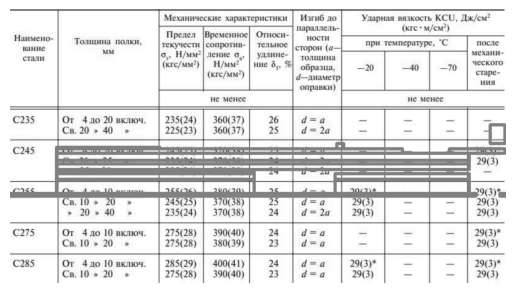

In [114]:
extractor = TableExtraction()
extractor.extract_from_file('draft/6_part.pdf')

In [108]:
extractor.tables[0].shape

(926, 1679)